In [2]:
import pandas as pd
import os
import numpy as np
import statsmodels.stats.multitest as multi
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

## Get association files

In [4]:
directory="/cellar/users/mpagadal/Data2/projects/germline-immune/disease-relevance/associations/metal/partial.sd.coding/"
files=[x for x in os.listdir(directory) if "add" in x]

In [5]:
files.remove("melanoma.assoc.logistic.add")
files.remove("rcc.assoc.logistic.add")
files.remove("nsclc.assoc.logistic.add")

In [6]:
files

['hugo.assoc.logistic.add',
 'miao.assoc.logistic.add',
 'rizvi.assoc.logistic.add',
 'vanallen.assoc.logistic.add',
 'snyder.assoc.logistic.add',
 'riaz.assoc.logistic.add']

In [7]:
files=[x.split(".")[0] for x in files]

In [8]:
compiled_freq=pd.DataFrame()

for x in files:
    f=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/disease-relevance/associations/metal/partial.sd.coding/"+x+".freq.afreq",delimiter="\t")
    df=f[f["ALT_FREQS"]>.01]
    df["study"]=x
    compiled_freq=compiled_freq.append(df)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### keep only ids that are MAF > 1% in at least 6 studies

In [9]:
compiled_counts=compiled_freq["ID"].value_counts().reset_index()

In [10]:
len(compiled_counts[compiled_counts["ID"]>5])

69

In [11]:
icb_snps=pd.DataFrame({"snps":compiled_counts[compiled_counts["ID"]>5]["index"].tolist()})
icb_snps.to_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/icb_snps.txt",header=None,index=None,sep="\t")

In [12]:
compiled_or=pd.DataFrame()

for x in files:
    f=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/disease-relevance/associations/metal/partial.sd.coding/"+x+".assoc.logistic.add",delimiter="\t")
    f["study"]=x
    compiled_or=compiled_or.append(f)

In [13]:
compiled_or["snp_noallele"]=compiled_or["ID"].str.rsplit(":",2).str[0]

## Get METAL results

In [14]:
#get metal analysis results
df=pd.read_csv("/cellar/users/mpagadal/Programs/metal/p-pooling/METAANALYSIS1.TBL",delimiter="\t")
df=df.sort_values(by="P-value")

In [15]:
def fdr(df,p):
    #calculate benjamin-hochberg fdr
    probabilities = df[p].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    return(df)

In [16]:
df=df.reset_index()

In [17]:
df=df[df["MarkerName"].isin(compiled_counts[compiled_counts["ID"]>5]["index"].tolist())]

In [18]:
def ppoints(n, a):
    """ numpy analogue or `R`'s `ppoints` function
        see details at http://stat.ethz.ch/R-manual/R-patched/library/stats/html/ppoints.html 
        :param n: array type or number"""
    try:
        n = np.float(len(n))
    except TypeError:
        n = np.float(n)
    return (np.arange(n) + 1 - a)/(n + 1 - 2*a)

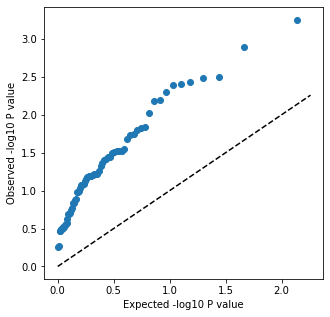

In [19]:
compiled=pd.DataFrame()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
p_values=df.sort_values(by="P-value")["P-value"].tolist()
plt.scatter(-np.log10(ppoints(len(p_values), 1./2)), -np.log10(p_values))
ax.plot([0,ax.get_xlim()[1]], [0,ax.get_xlim()[1]], ls="--", c="k")
ax.set_xlabel("Expected -log10 P value")
ax.set_ylabel('Observed -log10 P value')
plt.savefig("../plots/qq.pdf")

## Filter for variants with FDR < 10%

In [20]:
df=fdr(df,"P-value")

In [21]:
df["snp_noallele"]=df["MarkerName"].str.rsplit(":",2).str[0]

In [22]:
snps=pd.read_csv("../../snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")
snps["snp_noallele"]=snps["snps"].str.rsplit(":",2).str[0]

In [23]:
df=pd.merge(df,snps[["snp_noallele","REF","ALT","tpm beta","file"]],on="snp_noallele")

In [24]:
df.to_csv("../data/icb-snps.tsv",index=None,sep="\t")

In [25]:
len(df["file"].unique())

33

In [28]:
for x in df[df["-log10(fdr)"]>1]["file"].unique().tolist():
    print(x)

SLC11A1
LAIR1
CCBL2
LILRB2
CTSW
CTSS
LYZ
B2M
SLC25A40
LILRB4
ERAP2
HAUS1
TREX1
PSMD2
SIGLEC5
FCGR2B


## Get effect size METAL results

In [269]:
#get metal analysis results
df2=pd.read_csv("/cellar/users/mpagadal/Programs/metal/effect-sizes/METAANALYSIS1.TBL",delimiter="\t")
df2=df2.sort_values(by="P-value")
df2=df2[df2["MarkerName"].isin(compiled_counts[compiled_counts["ID"]>5]["index"].tolist())]

In [270]:
df2=fdr(df2,"P-value")

In [271]:
df2.sort_values(by="fdr")

,MarkerName,Allele1,Allele2,Effect,StdErr,P-value,Direction,fdr,-log10(fdr)
261,12:69744014:C:A,a,c,1.1768,0.4259,0.005728,++++++,0.395232,0.403148
122,1:150678910:T:C,t,c,-0.6342,0.2732,0.020250,+-----,0.573218,0.241681
131,3:184026703:C:T,t,c,0.3752,0.1709,0.028170,++-+++,0.573218,0.241681
23,1:161600109:C:T,t,c,0.9934,0.4665,0.033230,++++++,0.573218,0.241681
178,11:66040049:G:C,c,g,-0.4225,0.2170,0.051510,------,0.651274,0.186236
...,...,...,...,...,...,...,...,...,...
246,5:79811662:G:A,a,g,-0.0935,0.2093,0.655200,-+-+--,0.961300,0.017141
40,5:96413647:G:T,t,g,-0.0979,0.2160,0.650500,--+---,0.961300,0.017141
338,19:54849399:T:C,t,c,-0.0166,0.3158,0.958100,+--+-+,0.961300,0.017141
153,1:89477830:T:C,t,c,-0.0527,0.2368,0.824000,-+--+-,0.961300,0.017141


In [272]:
df_total=pd.merge(df_sig,df2,on="MarkerName",suffixes=("_p","_effect"))

In [273]:
df_total

,index,MarkerName,Allele1_p,Allele2_p,Weight,Zscore,P-value_p,Direction_p,fdr_p,-log10(fdr)_p,...,tpm beta,file,Allele1_effect,Allele2_effect,Effect,StdErr,P-value_effect,Direction_effect,fdr_effect,-log10(fdr)_effect
0,228,2:219259844:A:G,a,g,378.0,-3.447,0.000566,------,0.039047,1.408411,...,0.104571,SLC11A1,a,g,0.0658,0.1982,0.739800,+++---,0.961300,0.017141
1,118,19:54848986:C:T,t,c,378.0,3.219,0.001289,++++++,0.040119,1.396655,...,-0.189505,LAIR1,t,c,0.0785,0.2005,0.695500,++-+-+,0.961300,0.017141
2,184,1:89473624:G:A,a,g,378.0,2.952,0.003158,++++++,0.040119,1.396655,...,-0.208965,CCBL2,a,g,0.1257,0.1877,0.503000,-+---+,0.958793,0.018275
3,345,1:89735314:G:A,a,g,378.0,2.942,0.003257,++++++,0.040119,1.396655,...,0.137199,CCBL2,a,g,0.0151,0.3122,0.961300,+-+++-,0.961300,0.017141
4,104,19:54754385:T:G,t,g,378.0,-2.902,0.003707,------,0.040119,1.396655,...,0.139727,LILRB2,t,g,-0.1765,0.2570,0.492200,+--++-,0.958793,0.018275
5,69,11:65561369:G:A,a,g,378.0,2.883,0.003942,++++++,0.040119,1.396655,...,0.113429,CTSW,a,g,-0.0732,0.2435,0.763500,-++-++,0.961300,0.017141
6,122,1:150678910:T:C,t,c,378.0,-2.873,0.004070,------,0.040119,1.396655,...,0.126770,CTSS,t,c,-0.6342,0.2732,0.020250,+-----,0.573218,0.241681
7,261,12:69744014:C:A,a,c,378.0,2.811,0.004939,++++++,0.042599,1.370602,...,0.176987,LYZ,a,c,1.1768,0.4259,0.005728,++++++,0.395232,0.403148
8,231,1:89478868:G:A,a,g,378.0,2.726,0.006407,++++++,0.046085,1.336439,...,0.129896,CCBL2,a,g,-0.2858,0.2341,0.222100,+--+--,0.958793,0.018275
9,271,15:42439444:C:T,t,c,378.0,2.712,0.006679,++++++,0.046085,1.336439,...,0.240991,B2M,t,c,0.2076,0.3142,0.508700,+++---,0.958793,0.018275


## Get Odds Ratio

In [293]:
compiled_icb=pd.DataFrame()

for x in files:
    df=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/disease-relevance/associations/metal/partial.sd.coding/"+x+".assoc.logistic.add",delimiter="\t")
    df["study"]=x
    compiled_icb=compiled_icb.append(df)

In [294]:
compiled_icb_plot=compiled_icb[compiled_icb["ID"].isin(df_sig["MarkerName"].tolist())]

In [295]:
compiled_icb_plot["logOR"]=np.log10(compiled_icb_plot["OR"])

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [297]:
compiled_icb_plot["-log10p"]=-np.log10(compiled_icb_plot["P"])

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


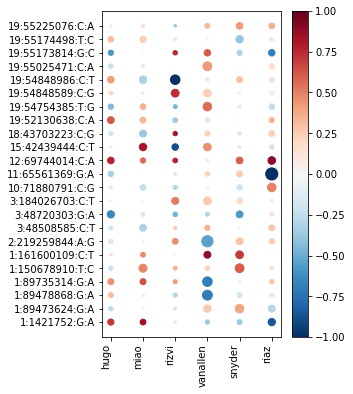

In [301]:
def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(4, 6))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 50
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-1, vmax=1# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
heatmap(
    x=compiled_icb_plot['study'],
    y=compiled_icb_plot['ID'],
    size=compiled_icb_plot['-log10p'],
    color=compiled_icb_plot['logOR'],
)


In [298]:
compiled_icb_plot

,#CHROM,POS,ID,REF,ALT,A1,FIRTH?,TEST,OBS_CT,OR,LOG(OR)_SE,Z_STAT,P,ERRCODE,study,logOR,-log10p
0,1,1421752,1:1421752:G:A,G,A,A,N,ADD,38,5.054600,1.168580,1.386550,0.165580,.,hugo,0.703687,0.780992
40,1,89473624,1:89473624:G:A,G,A,A,N,ADD,38,0.549515,0.720945,-0.830466,0.406275,.,hugo,-0.260020,0.391180
42,1,89478868,1:89478868:G:A,G,A,A,N,ADD,38,2.089880,0.756420,0.974469,0.329824,.,hugo,0.320121,0.481718
43,1,89735314,1:89735314:G:A,G,A,A,N,ADD,38,2.880610,0.813718,1.300210,0.193530,.,hugo,0.459484,0.713252
47,1,150678910,1:150678910:T:C,T,C,C,N,ADD,38,0.591726,0.680662,-0.770884,0.440776,.,hugo,-0.227879,0.355782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,19,54848986,19:54848986:C:T,C,T,T,N,ADD,67,1.530640,0.485570,0.876676,0.380663,.,riaz,0.184873,0.419459
455,19,55025471,19:55025471:C:A,C,A,A,N,ADD,67,1.538530,0.415188,1.037670,0.299425,.,riaz,0.187106,0.523712
462,19,55173814,19:55173814:G:C,G,C,C,N,ADD,67,0.202450,1.094930,-1.458780,0.144625,.,riaz,-0.693682,0.839757
463,19,55174498,19:55174498:T:C,T,C,C,N,ADD,67,1.332300,0.413968,0.693072,0.488264,.,riaz,0.124602,0.311345


In [290]:
compiled_OR=compiled_icb_plot.pivot(index="ID",columns="study",values=["logOR","P","A1"])
compiled_OR.to_csv("../data/TIME.icb.OR.tsv",sep="\t")

In [291]:
compiled_icb_p=compiled_icb_plot.pivot(index="ID",columns="study",values="P")

In [292]:
compiled_icb_p

study,hugo,miao,riaz,rizvi,snyder,vanallen
ID,,,,,,
10:71880791:C:G,0.637409,0.228868,0.034990,0.417326,0.255151,0.737806
11:65561369:G:A,0.275193,0.957946,0.001110,0.662309,0.200401,0.363292
12:69744014:C:A,0.134031,0.272774,0.071126,0.360844,0.123683,0.702190
15:42439444:C:T,0.817623,0.082397,0.436286,0.140865,0.681971,0.069819
18:43703223:C:G,0.456412,0.115592,0.223314,0.420858,0.571678,0.329538
19:52130638:C:A,0.119225,0.192573,0.341866,0.375700,0.967783,0.405087
19:54754385:T:G,0.283656,0.223383,0.252428,0.482178,0.573096,0.035076
19:54848589:C:G,0.512664,0.694457,0.548787,0.059303,0.717307,0.067911
19:54848986:C:T,0.128097,0.075472,0.380663,0.015446,0.193457,0.508676


In [281]:
compiled_icb_plot.head()

study,hugo,miao,riaz,rizvi,snyder,vanallen
ID,,,,,,
10:71880791:C:G,-0.119713,-0.236264,0.496082,-0.275416,-0.218184,-0.058087
11:65561369:G:A,-0.329322,0.011334,-1.015679,0.164073,0.265030,0.226682
12:69744014:C:A,0.765794,0.568960,0.895561,0.767899,0.594195,0.124113
15:42439444:C:T,0.084844,0.828196,-0.203600,-0.885009,-0.138755,0.455922
18:43703223:C:G,-0.193314,-0.376709,0.248057,0.836161,-0.155138,0.248927


In [282]:
col=[]

for x in compiled_icb_plot.columns:
    print(x)
    if x in ["hugo","riaz","snyder","vanallen"]:
        col.append("green")
    elif x in ["rizvi"]:
        col.append("red")
    else:
        col.append("blue")
        

hugo
miao
riaz
rizvi
snyder
vanallen


In [283]:
col2=[]

for x in compiled_icb_plot.columns:
    if x in ["snyder","vanallen",]:
        col2.append("purple") #ctla4
    elif x in ["miao","riaz"]:
        col2.append("pink") #both ctla4, pdl1
    else:
        col2.append("orange") #pdl1

In [284]:
compiled_icb_plot=compiled_icb_plot.fillna(0)

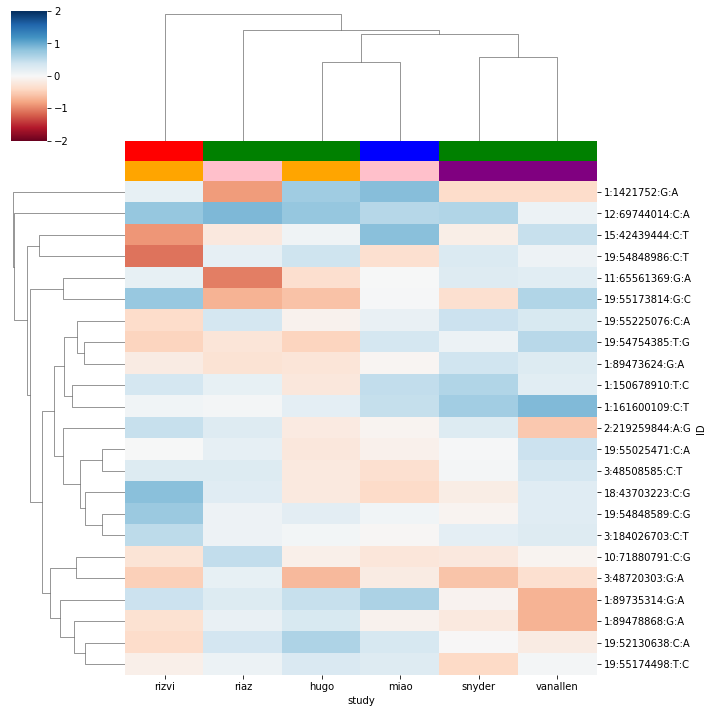

In [285]:
sns.clustermap(compiled_icb_plot,vmin=-2,vmax=2,col_colors=[col,col2],cmap="RdBu")
plt.savefig("../plots/icb.clustermap.pdf")

In [286]:
compiled_icb_plot

study,hugo,miao,riaz,rizvi,snyder,vanallen
ID,,,,,,
10:71880791:C:G,-0.119713,-0.236264,0.496082,-0.275416,-0.218184,-0.058087
11:65561369:G:A,-0.329322,0.011334,-1.015679,0.164073,0.265030,0.226682
12:69744014:C:A,0.765794,0.568960,0.895561,0.767899,0.594195,0.124113
15:42439444:C:T,0.084844,0.828196,-0.203600,-0.885009,-0.138755,0.455922
18:43703223:C:G,-0.193314,-0.376709,0.248057,0.836161,-0.155138,0.248927
19:52130638:C:A,0.617743,0.331008,0.363834,-0.364045,-0.010200,-0.166382
19:54754385:T:G,-0.444745,0.352348,-0.253081,-0.449256,0.112035,0.557223
19:54848589:C:G,0.205229,0.067056,0.106014,0.739050,-0.058982,0.248493
19:54848986:C:T,0.420235,-0.322913,0.184873,-1.081089,0.291469,0.103075


## Annotate samples

In [31]:
snps=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")

In [32]:
snps["assoc"]=snps["snps"]+"_"+snps["file"]

In [33]:
mp_assoc=dict(zip(snps["snps"],snps["assoc"]))

In [34]:
compiled_icb_plot["pheno"]=compiled_icb_plot.index.map(mp_assoc)

In [35]:
for x in set([x.split("_")[1] for x in compiled_icb_plot["pheno"]]):
    print(x)

SLC25A40
CTSW
LILRB2
LAIR1
SLC11A1
LILRB4
LYZ
PSMD2
CTSS
TREX1
CCBL2


In [58]:
snps[snps["snps"].isin(icb_snps["snps"].tolist())]

,snps,file,category,maf,variant,rsid,tpm beta,tpm SE,tpm P,REF,ALT,firebrowse beta,firebrowse SE,firebrowse P,pancan beta,pancan SE,pancan P,p-value,cis tss,assoc
54,19:54848986:C:T,LAIR1,immunomodulators,0.21680,chr19:g.54848986C>T,rs36068997,-0.189505,0.020223,9.480300e-21,C,T,0.004545,0.020622,8.255600e-01,0.004824,0.020248,8.117140e-01,9.480300e-21,16248.0,19:54848986:C:T_LAIR1
61,19:54848589:C:G,LAIR1,immunomodulators,0.25260,chr19:g.54848589C>G,rs113109589,0.147105,0.019317,2.971350e-14,C,G,0.025998,0.019675,1.864260e-01,0.027989,0.019343,1.479620e-01,2.971350e-14,16645.0,19:54848589:C:G_LAIR1
62,19:54849399:T:C,LAIR1,immunomodulators,0.07198,chr19:g.54849399T>C,rs10419832,-0.241417,0.031978,4.921460e-14,T,C,-0.054045,0.032544,9.682900e-02,-0.045744,0.032020,1.531620e-01,4.921460e-14,15835.0,19:54849399:T:C_LAIR1
71,19:54800371:T:C,LILRB2,antigen present,0.27770,chr19:g.54800371T>C,rs410852,-0.246490,0.018271,5.627670e-41,T,C,-0.053450,0.018888,4.670310e-03,-0.057569,0.018536,1.904980e-03,5.627670e-41,-22697.0,19:54800371:T:C_LILRB2
77,19:54754385:T:G,LILRB2,antigen present,0.33260,chr19:g.54754385T>G,rs2361796,0.139727,0.017345,9.210950e-16,T,G,-0.018438,0.017799,3.002820e-01,-0.022086,0.017484,2.065590e-01,9.210950e-16,23289.0,19:54754385:T:G_LILRB2
78,19:54743056:C:T,LILRB2,antigen present,0.13670,chr19:g.54743056C>T,rs10401694,0.189658,0.023879,2.286910e-15,C,T,-0.019792,0.024470,4.186530e-01,-0.016336,0.024096,4.978270e-01,2.286910e-15,34618.0,19:54743056:C:T_LILRB2
84,19:54687334:C:G,LILRB2,antigen present,0.47380,chr19:g.54687334C>G,rs254283,0.090547,0.016742,6.571640e-08,C,G,0.039079,0.017121,2.248600e-02,0.035129,0.016826,3.685530e-02,6.571640e-08,90340.0,19:54687334:C:G_LILRB2
88,1:150678910:T:C,CTSS,immunomodulators,0.39710,chr1:g.150678910T>C,rs1336899,0.126770,0.017082,1.296960e-13,T,C,0.132358,0.017305,2.309320e-14,0.138944,0.017029,3.957010e-16,3.957010e-16,23761.0,1:150678910:T:C_CTSS
94,1:79100762:A:T,IFI44L,immunomodulators,0.33500,chr1:g.79100762A>T,rs273255,-0.110721,0.017772,4.929690e-10,A,T,-0.043332,0.018101,1.669990e-02,-0.040502,0.017758,2.258630e-02,4.929690e-10,-14675.0,1:79100762:A:T_IFI44L
97,11:60103112:T:C,MS4A4A,cell type,0.32180,chr11:g.60103112T>C,rs12798157,0.104509,0.017756,4.139830e-09,T,C,0.112073,0.018040,5.523400e-10,0.111128,0.017708,3.687790e-10,3.687790e-10,-55099.0,11:60103112:T:C_MS4A4A


In [48]:
icb_snps

,snps
0,19:55025471:C:A
1,11:65392357:G:A
2,19:55174498:T:C
3,5:96233463:C:G
4,19:54752624:T:C
...,...
64,19:52130488:G:A
65,15:42439444:C:T
66,1:89478868:G:A
67,1:79100762:A:T
